In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
import numpy as np
import matplotlib.pyplot as plt
import time
import emcee
import scipy
import numpy as np
import pandas as pd

In [2]:
class HamiltonianMonteCarlo:
    def __init__(self, U, grad_U, epsilon, L, M):
        self.U = U  # Potential energy function
        self.grad_U = grad_U  # Gradient of the potential energy function
        self.epsilon = epsilon  # Step size
        self.L = L  # Number of leapfrog steps
        self.M = M  # Mass matrix
        self.M_inv = jnp.linalg.inv(M)  # Inverse of the mass matrix
        self.samples = None  # Placeholder for sampled points
        self.time = None  # Placeholder for sampling time
        self.acceptance_rate = None  # Placeholder for acceptance rate
        self.mean = None  # Placeholder for mean of samples
        self.covariance = None  # Placeholder for covariance of samples
    
    def leapfrog(self, q, p):
        p = p - 0.5 * self.epsilon * self.grad_U(q)
        for _ in range(self.L):
            q = q + self.epsilon * jnp.dot(self.M_inv, p)
            if _ < self.L - 1:
                p = p - self.epsilon * self.grad_U(q)
        p = p - 0.5 * self.epsilon * self.grad_U(q)
        return q, p

    def sample(self, key, num_samples):
        start_time = time.time()
        samples = []
        accepted = 0

        q = jnp.zeros(self.M.shape[0])  # Initial position
        for _ in range(num_samples):
            key, subkey = random.split(key)
            p = random.normal(subkey, shape=q.shape) * jnp.sqrt(jnp.diag(self.M))

            current_q = q
            current_p = p

            q, p = self.leapfrog(current_q, current_p)

            current_U = self.U(current_q)
            current_K = 0.5 * jnp.dot(current_p, jnp.dot(self.M_inv, current_p))
            proposed_U = self.U(q)
            proposed_K = 0.5 * jnp.dot(p, jnp.dot(self.M_inv, p))

            acceptance_prob = jnp.exp(current_U - proposed_U + current_K - proposed_K)
            if random.uniform(subkey) < acceptance_prob:
                samples.append(q)
                accepted += 1
            else:
                samples.append(current_q)
        
        end_time = time.time()
        self.samples = jnp.array(samples)
        self.time = end_time - start_time
        self.acceptance_rate = accepted / num_samples
        self.mean = jnp.mean(self.samples, axis=0)
        self.covariance = jnp.cov(self.samples, rowvar=False)


In [3]:
path = 'HMC_data/'

In [4]:
def multivariate_gaussian(x, mean, cov):
    diff = x - mean
    return 0.5 * jnp.dot(diff, jnp.linalg.solve(cov, diff))

# The target distribution is proportional to exp(-multivariate_gaussian(x))
def target_distribution_gauss_2d(x):
    mean = jnp.array([1.0, -1.5])
    cov = jnp.array([[4.0, 0.7], [0.7, 1.5]])  # Example covariance matrix
    return multivariate_gaussian(x, mean, cov)

grad_U = jit(grad(target_distribution_gauss_2d))
epsilon = 0.1
L = 10
M = jnp.eye(2)  # Identity matrix for simplicity




# Sample sizes to test
sample_sizes = [10000, 50000, 100000]
results = {}
key = random.PRNGKey(0)
# Sampling procedure
for size in sample_sizes:

    key, subkey = random.split(key)
    HM_gauss_2d = HamiltonianMonteCarlo(target_distribution_gauss_2d, grad_U, epsilon, L, M)
    HM_gauss_2d.sample(key, size)
    ar = HM_gauss_2d.acceptance_rate
    ar = np.array([ar,ar])
    samples_with_acceptance = np.vstack((ar,HM_gauss_2d.samples))
    results[size] = samples_with_acceptance

# Save the results

for size in sample_sizes:
    df = pd.DataFrame(results[size])
    filename = f"HMC_samples_2D_{size}.csv"
    df.to_csv(path+filename, index=False)

In [5]:
def target_distribution_gauss_15d(x):
    mean = jnp.ones(15)
    cov = jnp.eye(15)* 0.5 + 0.5 
    return multivariate_gaussian(x, mean, cov)

grad_U = jit(grad(target_distribution_gauss_15d))
epsilon = 0.1
L = 5
M = jnp.eye(15)  # Identity matrix for simplicity
num_samples = 50000
key = random.PRNGKey(0)

HM_gauss_15d = HamiltonianMonteCarlo(target_distribution_gauss_15d, grad_U, epsilon, L, M)

# Sample sizes to test
sample_sizes = [10000, 50000, 100000]
results = {}
key = random.PRNGKey(0)

# Sampling procedure
for size in sample_sizes:
    key, subkey = random.split(key)
    HM_gauss_15d.sample(key, size)
    samples_with_acceptance = np.insert(HM_gauss_15d.samples, 0, HM_gauss_15d.acceptance_rate, axis=0)
    results[size] = samples_with_acceptance

# Save the results

for size in sample_sizes:
    df = pd.DataFrame(results[size])
    filename = f"HMC_samples_15D_{size}.csv"
    df.to_csv(path+filename, index=False)

In [6]:
# Define the 2-dimensional Rosenbrock function
def rosenbrock(x):
    a = 1.0
    b = 100.0
    return (a - x[0])**2 + b * (x[1] - x[0]**2)**2

# The target distribution is proportional to exp(-rosenbrock(x))
def target_distribution_rosenbrock(x):
    return rosenbrock(x)

grad_U = jit(grad(target_distribution_rosenbrock))
epsilon = 0.001  # Smaller step size for the Rosenbrock function
L = 100  # More steps to better explore the steep regions
M = jnp.eye(2)  # Identity mass matrix
num_samples = 50000
key = random.PRNGKey(0)

HM_gauss_rosenbrock = HamiltonianMonteCarlo(target_distribution_rosenbrock, grad_U, epsilon, L, M)

# Sample sizes to test
sample_sizes = [10000, 50000, 100000]
results = {}
key = random.PRNGKey(0)

# Sampling procedure
for size in sample_sizes:
    key, subkey = random.split(key)
    HM_gauss_rosenbrock.sample(key, size)
    samples_with_acceptance = np.insert(HM_gauss_rosenbrock.samples, 0, HM_gauss_rosenbrock.acceptance_rate, axis=0)
    results[size] = samples_with_acceptance

# Save the results

for size in sample_sizes:
    df = pd.DataFrame(results[size])
    filename = f"HMC_samples_RB_{size}.csv"
    df.to_csv(path+filename, index=False)

In [7]:
HM_gauss_rosenbrock.sample(key, num_samples)

KeyboardInterrupt: 

In [ ]:
ac_rb = emcee.autocorr.integrated_time(HM_gauss_rosenbrock.samples)

In [8]:
HM_gauss_rosenbrock.acceptance_rate

0.99988

In [ ]:
print(ac_rb)

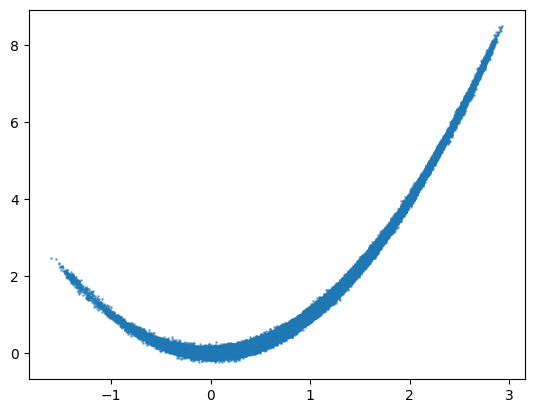

In [9]:
plt.scatter(HM_gauss_rosenbrock.samples[:,0], HM_gauss_rosenbrock.samples[:,1], s=1,alpha=0.5)